In this part, TF-IDF, Word2Vec, and LSTM are tried to understand how different model will influence the result.In addition, this time only log loss from sklearn.metrics are used. 
References: [Basic NLP: Bag of Words, TF-IDF, Word2Vec, LSTM](https://www.kaggle.com/reiinakano/basic-nlp-bag-of-words-tf-idf-word2vec-lstm)

In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer

from sklearn.model_selection import train_test_split,cross_val_predict,StratifiedKFold

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import log_loss, accuracy_score

import gensim

import nltk

from xgboost import XGBClassifier

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM
from keras.utils.np_utils import to_categorical
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from keras.optimizers import Adam

import scikitplot.plotters as skplt

import warnings
warnings.filterwarnings('ignore')

import os

In [3]:
df = pd.read_csv('data/train_cln.csv', encoding='utf-8')

In [4]:
df.head(3)

,ID,Gene,Variation,Class,TEXT
0,0,FAM58A,Truncating Mutations,1,cyclin dependent kinases cdks regulate variety...
1,1,CBL,W802*,2,abstract background non small cell lung cancer...
2,2,CBL,Q249E,2,abstract background non small cell lung cancer...


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3321 entries, 0 to 3320
Data columns (total 5 columns):
ID           3321 non-null int64
Gene         3321 non-null object
Variation    3321 non-null object
Class        3321 non-null int64
TEXT         3316 non-null object
dtypes: int64(2), object(3)
memory usage: 129.8+ KB


In [9]:
df[df['TEXT'].isnull()]

,ID,Gene,Variation,Class,TEXT
1109,1109,FANCA,S1088F,1,NaN
1277,1277,ARID5B,Truncating Mutations,1,NaN
1407,1407,FGFR3,K508M,6,NaN
1639,1639,FLT1,Amplification,6,NaN
2755,2755,BRAF,G596C,7,NaN


In [10]:
df.dropna(inplace=True)

In [11]:
X = df.copy()
y = df['Class']

In [13]:
X_train, X_test, y_train, y_test = train_test_split(
...     X, y, test_size=0.3, random_state=42, stratify=y)

Text(0, 0.5, 'Proportion')

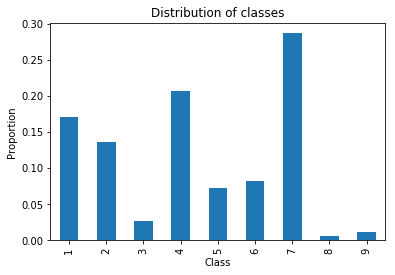

In [14]:
X_train['Class'].value_counts(normalize=True).sort_index().plot.bar()
plt.title('Distribution of classes')
plt.xlabel('Class')
plt.ylabel('Proportion')

In [39]:
def feature_eval(X,y,clf=None):
    """ Print out log loss, accuracy and plot confusion matrix for training data"""
    if clf is None:
        clf = LogisticRegression()
        
    probas = cross_val_predict(clf, X,y, cv=StratifiedKFold(random_state=101),
                              n_jobs=-1, method='predict_proba',verbose=2)
    pred_id = np.argmax(probas, axis=1)
    classes = np.unique(y)
    pred = classes[pred_id]
    print ('Log loss: {}'.format(log_loss(y,probas)))
    print ('Accuracy: {}'.format(accuracy_score(y, pred)))
    skplt.plot_confusion_matrix(y, pred)

Base mode: bag of words (count of words)

In [16]:
count_vectorizer = CountVectorizer(
analyzer='word', tokenizer=nltk.word_tokenize, preprocessor=None, stop_words='english')

In [17]:
train_text_cv = count_vectorizer.fit_transform(X_train['TEXT'])

In [18]:
len(count_vectorizer.get_feature_names())

129359

In [26]:
X_train.shape

(2321, 5)

For `TEXT` feautre, after using `CountVectorizer`, we obtain 129359 new feature columns, which is way more large comapred to rows (number of observations) in the train dataset.Here, we use truncated SVD to reduce the dimensionality into a smaller subset of features that are most relevant to the prediction problem.

According to scikitlearn documentation, truncated SVD " performs linear dimensionality reduction by means of truncated singular value decomposiiton (SVD). It can work with sparse matrics efficiently" [link](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html).

There is a detailed explanation on SVD , [link1](http://andrew.gibiansky.com/blog/mathematics/cool-linear-algebra-singular-value-decomposition/) and [link2](https://machinelearningmastery.com/singular-value-decomposition-for-machine-learning/)

In [19]:
# a breif example on singualr value decomposition
from scipy.linalg import svd

In [28]:
A = np.array([
	[1,2,3,4,5,6,7,8,9,10],
	[11,12,13,14,15,16,17,18,19,20],
	[21,22,23,24,25,26,27,28,29,30]])

In [32]:
print (A.shape)

(3, 10)


In [33]:
svd = TruncatedSVD(n_components=2)
result = svd.fit_transform(A)

In [34]:
result

array([[18.52157747,  6.47697214],
       [49.81310011,  1.91182038],
       [81.10462276, -2.65333138]])

In [35]:
print (result.shape)

(3, 2)


This is a simple exmaple to illustrate how SVD works to show that a matrix with 10 columns can be reduced to 2 columns by using SVD.

In [36]:
#reduce to 25 relevant features
svd = TruncatedSVD(n_components=25, n_iter=25, random_state=101)
trunc_train_text_cv = svd.fit_transform(train_text_cv)

In [37]:
trunc_train_text_cv.shape

(2321, 25)

Default logistic regression

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.9s finished


Log loss: 1.3977557619038523
Accuracy: 0.5032313657906075


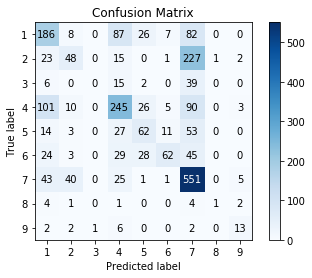

In [42]:
feature_eval(trunc_train_text_cv,y_train.values)

Random forest

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.5s finished


Log loss: 1.3671516206389864
Accuracy: 0.5411460577337355


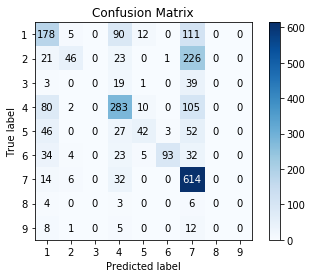

In [44]:
feature_eval(trunc_train_text_cv, y_train.values, RandomForestClassifier(
n_estimators=1000, max_depth=5, verbose=1))

It seems the base model does not perform very well as the overall accuracy is about 0.5 which is random guess. 

## TFIDF
Tf-idf stands for *term frequency-inverse document frequency*, and tf-idf weight is a weight often used in information retieval and text mining. The weight is a statistical measure used to evaluate how important a word is to a document in a corpus. **The importance increases proportionally to the number of times a word appears in the document but is offset by the frequency of the word in the corpus**. See more in [link1](http://www.tfidf.com/), [link2](https://en.wikipedia.org/wiki/Tf%E2%80%93idf)

In [45]:
tfidf_vectorizer= TfidfVectorizer(
                    analyzer='word',tokenizer=nltk.word_tokenize,
                    preprocessor=None, stop_words='english', max_features=None)

In [ ]:
train_tfidf = tfidf_vectorizer.fit_transform(X_train['TEXT'])

In [47]:
len(tfidf_vectorizer.get_feature_names())

129359

In [52]:
svd = TruncatedSVD(n_components=25, n_iter=30, random_state=101)
trunc_train_text_tfidf = svd.fit_transform(train_tfidf)

In [53]:
trunc_train_text_tfidf.shape

(2321, 25)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.9s finished


Log loss: 1.3959095100892365
Accuracy: 0.4941835415769065


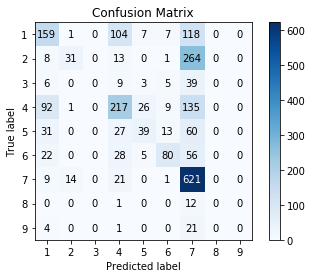

In [54]:
#default logsitic regression
feature_eval(trunc_train_text_tfidf, y_train.values)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.5s finished


Log loss: 1.2878024709773603
Accuracy: 0.5424386040499785


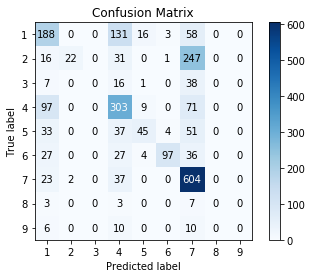

In [55]:
#random forest
feature_eval(trunc_train_text_tfidf, y_train.values, 
            RandomForestClassifier(n_estimators=1000, max_depth=5))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.7s finished


Log loss: 1.3396021948678354
Accuracy: 0.4959069366652305


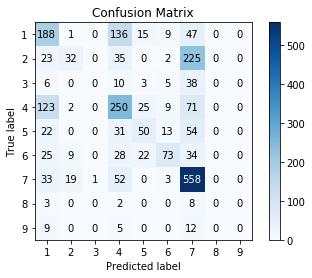

In [56]:
#linver SVC
feature_eval(trunc_train_text_tfidf, y_train.values, 
            SVC(kernel='linear', probability=True))

In [58]:
y_train.value_counts().sort_index()

1    396
2    317
3     62
4    480
5    170
6    191
7    666
8     13
9     26
Name: Class, dtype: int64

It seems that Random Forest tends to overfit and does not perform better comapred to Logistic Regression or Linear SVC. The model improves a little a bit, as we can see that only Class 7 has been classified correctly in most cases. 

## Word2vec

In [59]:
class MySentences(object):
    """MySentences is a generator to produce a list of tokenized sentences 
    
    Takes a list of numpy arrays containing documents.
    
    Args:
        arrays: List of arrays, where each element in the array contains a document.
    """
    def __init__(self, *arrays):
        self.arrays = arrays
 
    def __iter__(self):
        for array in self.arrays:
            for document in array:
                for sent in nltk.sent_tokenize(document):
                    yield nltk.word_tokenize(sent)

def get_word2vec(sentences, location):
    """Returns trained word2vec
    
    Args:
        sentences: iterator for sentences
        
        location (str): Path to save/load word2vec
    """
    if os.path.exists(location):
        print('Found {}'.format(location))
        model = gensim.models.Word2Vec.load(location)
        return model
    
    print('{} not found. training model'.format(location))
    model = gensim.models.Word2Vec(sentences, size=100, window=5, min_count=5, workers=4)
    print('Model done training. Saving to disk')
    model.save(location)
    return model

In [63]:
w2vec = get_word2vec(
    MySentences(
        X_train['TEXT'].values, 
        X_test['TEXT'].values
    ),
    'w2vmodel'
)

w2vmodel not found. training model
Model done training. Saving to disk


In [64]:
class MyTokenizer:
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        transformed_X = []
        for document in X:
            tokenized_doc = []
            for sent in nltk.sent_tokenize(document):
                tokenized_doc += nltk.word_tokenize(sent)
            transformed_X.append(np.array(tokenized_doc))
        return np.array(transformed_X)
    
    def fit_transform(self, X, y=None):
        return self.transform(X)

class MeanEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        # if a text is empty we should return a vector of zeros
        # with the same dimensionality as all the other vectors
        self.dim = len(word2vec.wv.syn0[0])

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = MyTokenizer().fit_transform(X)
        
        return np.array([
            np.mean([self.word2vec.wv[w] for w in words if w in self.word2vec.wv]
                    or [np.zeros(self.dim)], axis=0)
            for words in X
        ])
    
    def fit_transform(self, X, y=None):
        return self.transform(X)

In [66]:
mean_embedding_vectorizer = MeanEmbeddingVectorizer(w2vec)
mean_embedded = mean_embedding_vectorizer.fit_transform(X_train['TEXT'])

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.3s finished


Log loss: 1.148073425738649
Accuracy: 0.5777682033606204


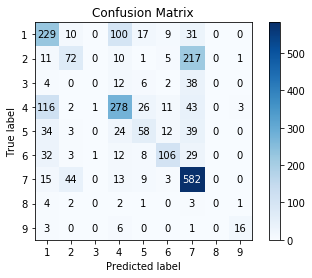

In [67]:
feature_eval(mean_embedded, y_train.values)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.9s finished


Log loss: 1.1360595464968888
Accuracy: 0.5906936665230504


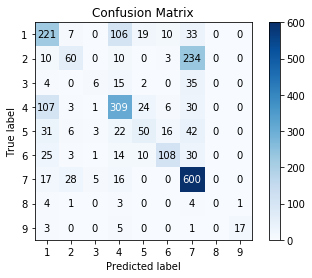

In [68]:
#linver SVC
feature_eval(mean_embedded, y_train.values, 
            SVC(kernel='linear', probability=True))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    5.9s finished


Log loss: 1.2465155355801742
Accuracy: 0.5872468763464024


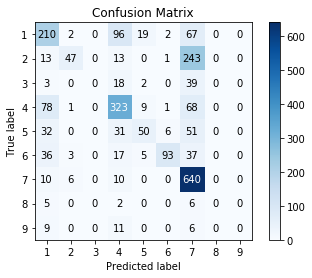

In [69]:
#random forest
feature_eval(mean_embedded, y_train.values, 
            RandomForestClassifier(n_estimators=1000, max_depth=5))

Using Word2Vec, the accuracy has been increased a lot. 